In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spotify-customer-churn-dataset/spotify_churn_dataset.csv


# Data Loading

In [2]:
df = pd.read_csv('/kaggle/input/spotify-customer-churn-dataset/spotify_churn_dataset.csv')

In [3]:
# cek data
print(df.shape)       # jumlah baris x kolom
print(df.columns)     # nama kolom
df.head()             # tampilkan 5 baris pertama

(1000, 10)
Index(['user_id', 'subscription_type', 'country', 'avg_daily_minutes',
       'number_of_playlists', 'top_genre', 'skips_per_day', 'support_tickets',
       'days_since_last_login', 'churned'],
      dtype='object')


,user_id,subscription_type,country,avg_daily_minutes,number_of_playlists,top_genre,skips_per_day,support_tickets,days_since_last_login,churned
0,user_1,Premium,US,134.9,4,Electronic,6,0,1,0
1,user_2,Premium,PK,165.7,5,Pop,8,0,12,0
2,user_3,Free,DE,45.9,3,Classical,3,0,3,0
3,user_4,Premium,PK,106.0,0,Jazz,7,0,3,0
4,user_5,Premium,US,89.6,5,Country,2,1,6,0


In [4]:
# tipe data setiap kolom
print(df.info())

# statistik deskriptif (untuk numerik)
print(df.describe())

# cek missing value
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                1000 non-null   object 
 1   subscription_type      1000 non-null   object 
 2   country                1000 non-null   object 
 3   avg_daily_minutes      1000 non-null   float64
 4   number_of_playlists    1000 non-null   int64  
 5   top_genre              1000 non-null   object 
 6   skips_per_day          1000 non-null   int64  
 7   support_tickets        1000 non-null   int64  
 8   days_since_last_login  1000 non-null   int64  
 9   churned                1000 non-null   int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 78.3+ KB
None
       avg_daily_minutes  number_of_playlists  skips_per_day  support_tickets  \
count        1000.000000          1000.000000    1000.000000      1000.000000   
mean           97.442100             3.4

# Data Cleaning & Preparation

In [5]:
# 1. Hapus duplikat
df = df.drop_duplicates()
print("Jumlah duplikat:", df.duplicated().sum())

# 2. Cek user_id unik
print("User ID unik:", df['user_id'].nunique())

# 3. Ubah tipe data kategori
for col in ['subscription_type', 'country', 'top_genre']:
    df[col] = df[col].astype('category')

# 4. Tangani nilai negatif di avg_daily_minutes
df.loc[df['avg_daily_minutes'] < 0, 'avg_daily_minutes'] = None  # ubah jadi NaN
df['avg_daily_minutes'].fillna(df['avg_daily_minutes'].median(), inplace=True)

# 5. Standardisasi kategori (contoh sederhana: huruf besar-kecil)
df['country'] = df['country'].str.strip().str.title()

# 6. Validasi logis
invalid = df[(df['churned'] == 1) & (df['days_since_last_login'] == 0)]
print("Baris churned tapi login hari ini:", len(invalid))

# 7. Cek distribusi churn
print(df['churned'].value_counts(normalize=True))

warnings.filterwarnings("ignore")

Jumlah duplikat: 0
User ID unik: 1000
Baris churned tapi login hari ini: 13
churned
0    0.814
1    0.186
Name: proportion, dtype: float64


/tmp/ipykernel_13/1126538325.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['avg_daily_minutes'].fillna(df['avg_daily_minutes'].median(), inplace=True)


In [6]:
# Drop user churned=1 tapi masih login hari ini
mask_inconsistent = (df['churned'] == 1) & (df['days_since_last_login'] == 0)
print("Jumlah baris inkonsisten:", mask_inconsistent.sum())

df = df[~mask_inconsistent].reset_index(drop=True)
print("Setelah dibersihkan:", df.shape)


Jumlah baris inkonsisten: 13
Setelah dibersihkan: (987, 10)


In [7]:
# Distribusi target setelah cleaning
print(df['churned'].value_counts(normalize=True))

# Simpan informasi imbalance untuk modeling nanti
churn_rate = df['churned'].mean()
print(f"Churn Rate: {churn_rate:.2%}")


churned
0    0.824721
1    0.175279
Name: proportion, dtype: float64
Churn Rate: 17.53%


1 = keluar / berhenti berlangganan

0 = tetap / masih aktif

In [8]:
# Ubah nilai negatif jadi NaN
df.loc[df['avg_daily_minutes'] < 0, 'avg_daily_minutes'] = None

# Imputasi dengan median
median_minutes = df['avg_daily_minutes'].median()
df['avg_daily_minutes'].fillna(median_minutes, inplace=True)

print("Nilai minimum avg_daily_minutes:", df['avg_daily_minutes'].min())


Nilai minimum avg_daily_minutes: 3.6


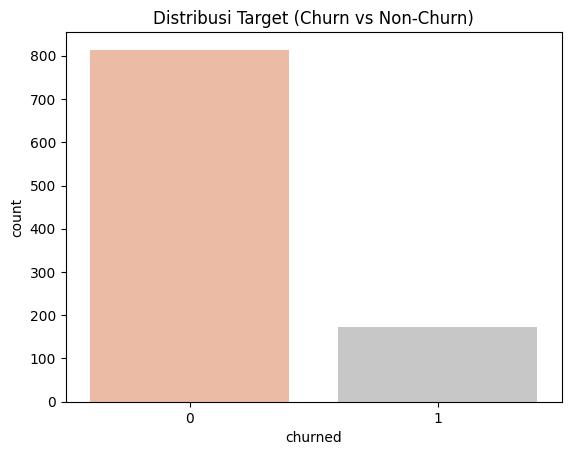

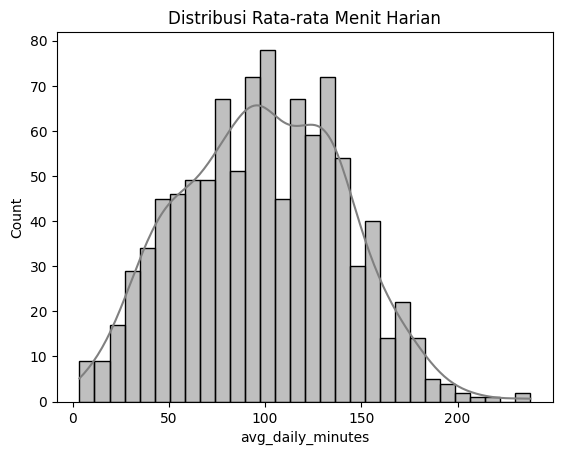

In [9]:
# Distribusi target churn
sns.countplot(x='churned', data=df, palette='RdGy' )
plt.title("Distribusi Target (Churn vs Non-Churn)")
plt.show()

# Distribusi avg_daily_minutes
sns.histplot(df['avg_daily_minutes'], bins=30, color='Grey', kde=True)
plt.title("Distribusi Rata-rata Menit Harian")
plt.show()


# Exploratory Data Analysis (EDA)

## Statistik Deskriptif

In [10]:
# ringkasan statistik numerik
print(df.describe())

# ringkasan kategorikal
print(df.describe(include='category'))


       avg_daily_minutes  number_of_playlists  skips_per_day  support_tickets  \
count         987.000000           987.000000     987.000000       987.000000   
mean           98.676393             3.443769       4.648430         0.225937   
std            41.760444             2.319253       2.772109         0.506165   
min             3.600000             0.000000       0.000000         0.000000   
25%            67.750000             1.500000       3.000000         0.000000   
50%            98.200000             3.000000       5.000000         0.000000   
75%           130.000000             5.000000       6.000000         0.000000   
max           237.800000            10.000000      14.000000         2.000000   

       days_since_last_login     churned  
count             987.000000  987.000000  
mean                9.621074    0.175279  
std                 9.744415    0.380398  
min                 0.000000    0.000000  
25%                 2.000000    0.000000  
50%         

## Distribusi Target

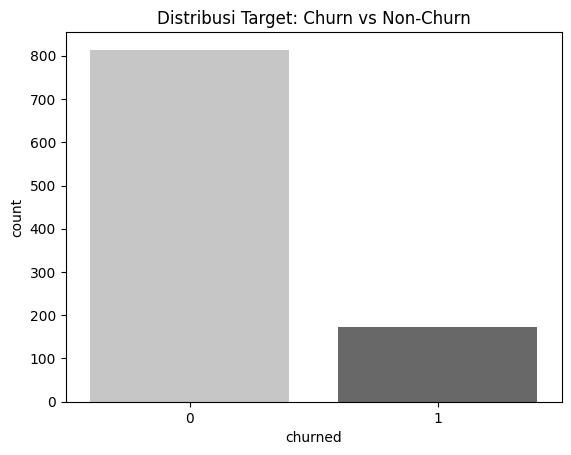

In [11]:
sns.countplot(x="churned", data=df, palette="Greys")
plt.title("Distribusi Target: Churn vs Non-Churn")
plt.show()

## Univariate Analysis

### Numerik → Histogram & KDE

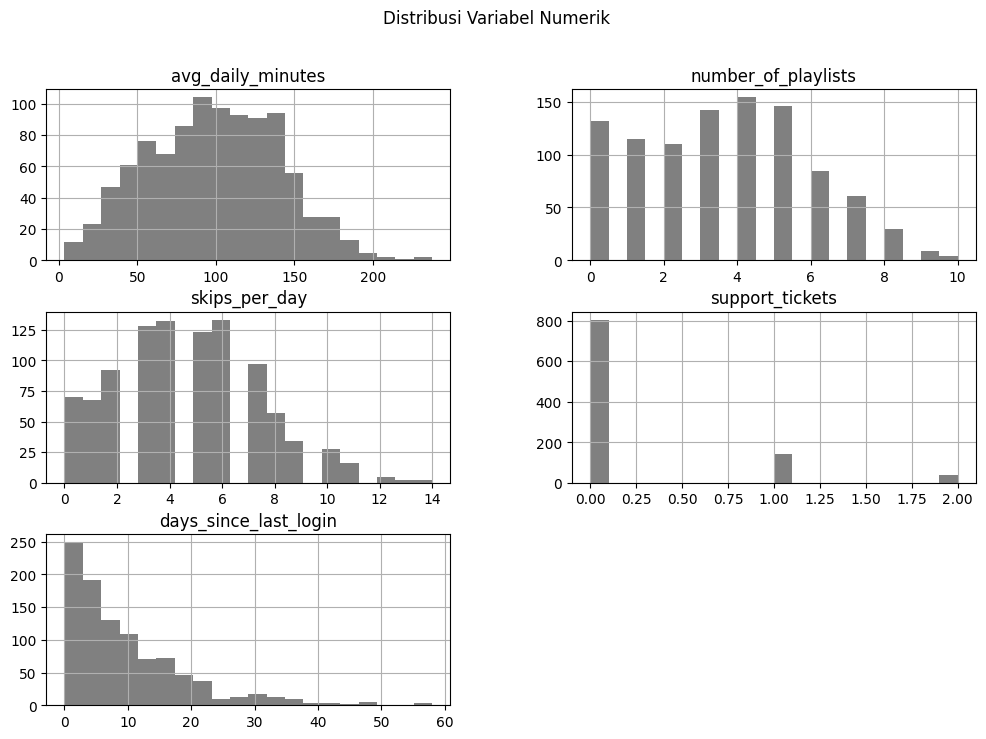

In [12]:
num_cols = ["avg_daily_minutes", "number_of_playlists", "skips_per_day", "support_tickets", "days_since_last_login"]

df[num_cols].hist(bins=20, figsize=(12,8), color='grey')

plt.suptitle("Distribusi Variabel Numerik")
plt.show()


### Kategorikal → Bar Chart

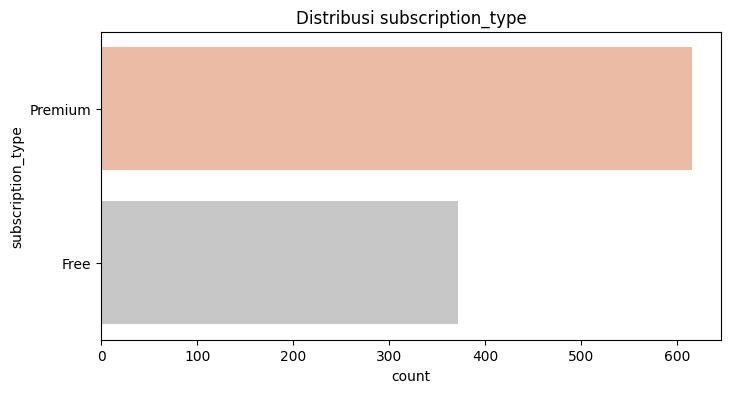

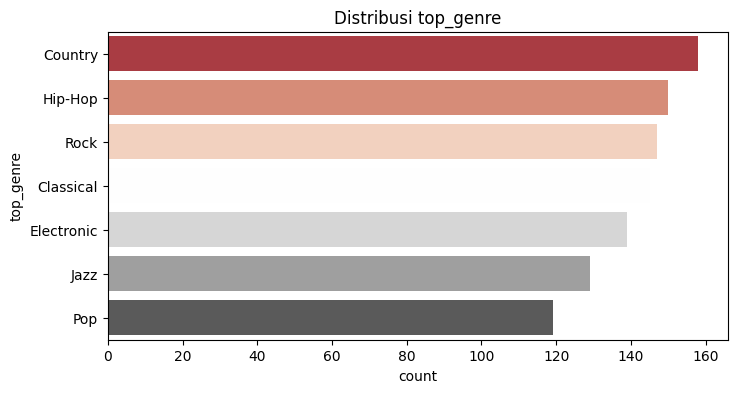

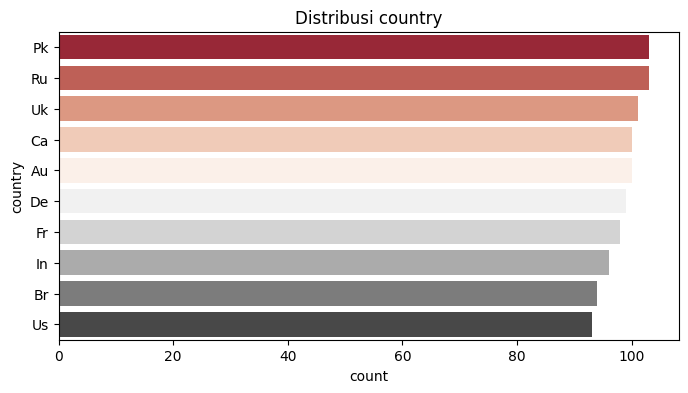

In [13]:
cat_cols = ["subscription_type", "top_genre", "country"]

for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette="RdGy")
    plt.title(f"Distribusi {col}")
    plt.show()


## Bivariate Analysis

### Numerik vs Target (Boxplot)

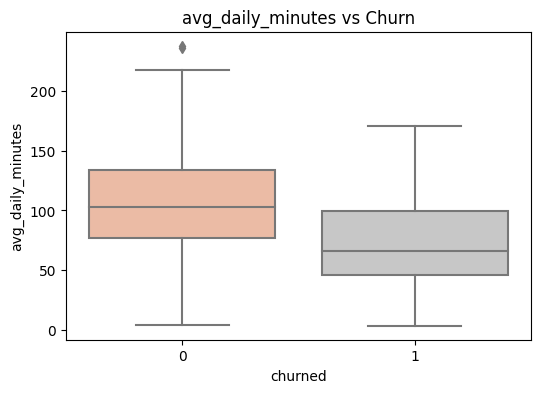

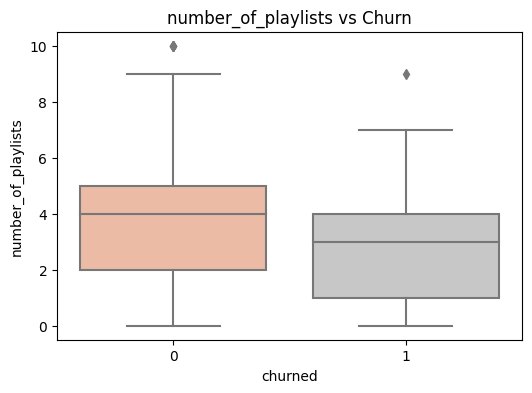

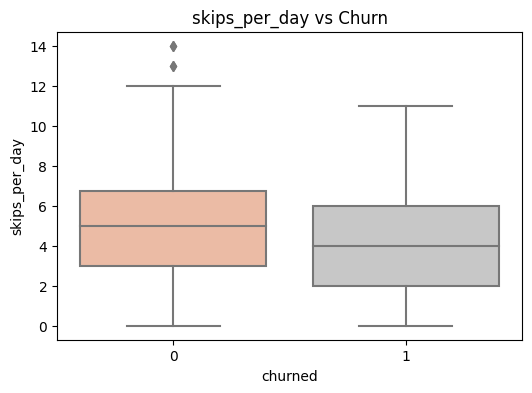

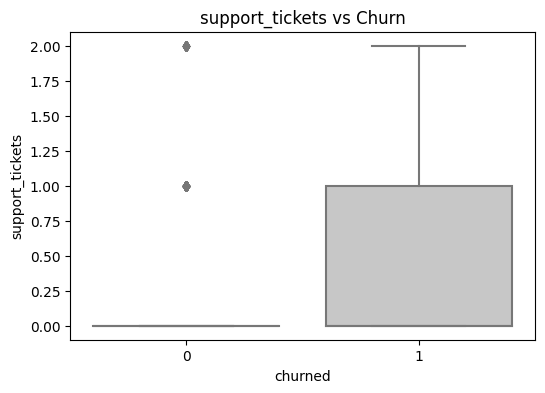

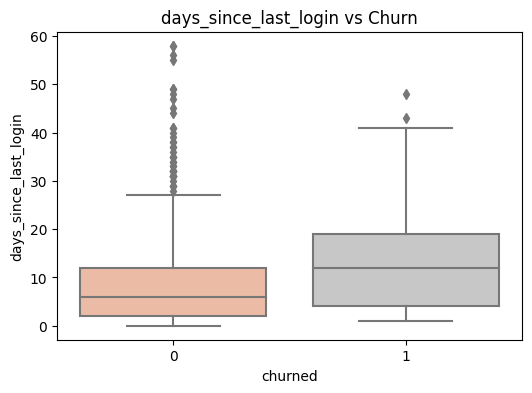

In [14]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="churned", y=col, data=df, palette="RdGy")
    plt.title(f"{col} vs Churn")
    plt.show()

### Kategorikal vs Target (Churn Rate per kategori)

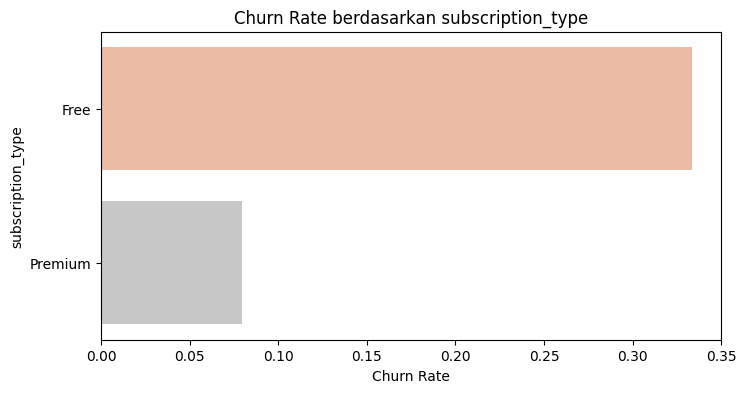

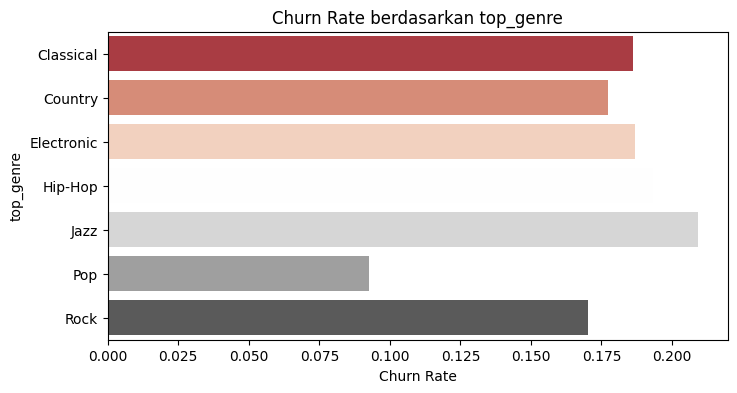

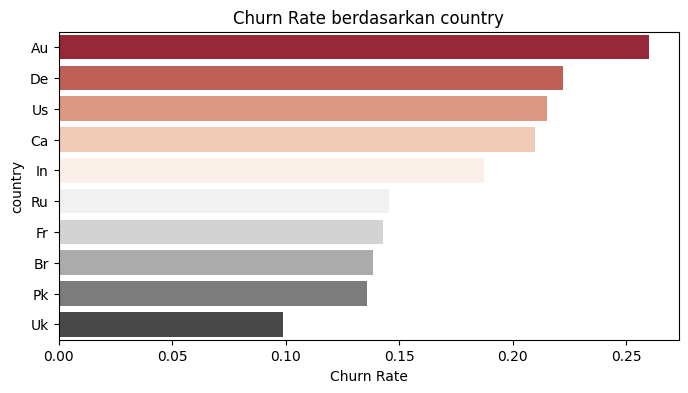

In [15]:
for col in cat_cols:
    churn_rate = df.groupby(col)["churned"].mean().sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    sns.barplot(x=churn_rate.values, y=churn_rate.index, palette="RdGy")
    plt.title(f"Churn Rate berdasarkan {col}")
    plt.xlabel("Churn Rate")
    plt.show()

## Multivariate Analysis

### Korelasi antar fitur numerik

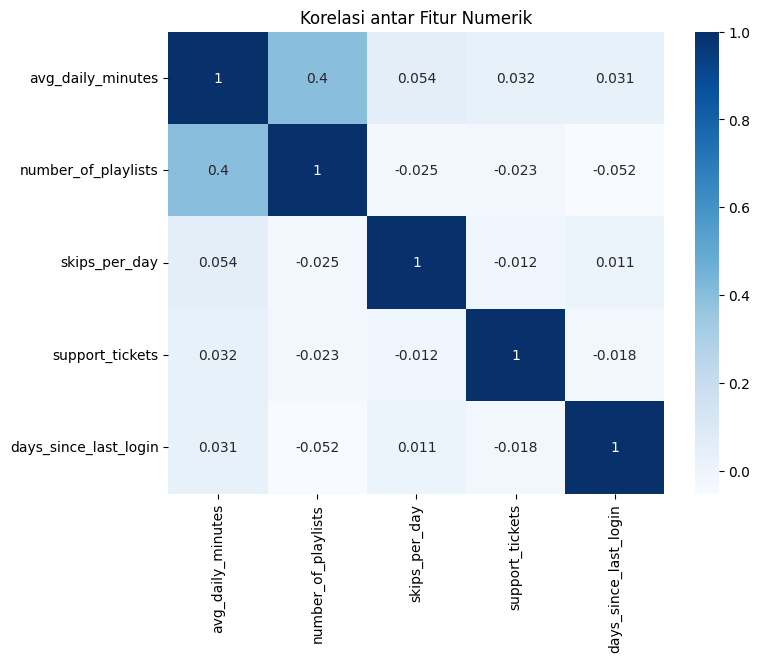

In [16]:
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="Blues")
plt.title("Korelasi antar Fitur Numerik")
plt.show()


### 🔹 Analysis (Interpretation of EDA)
1. Distribusi Target (Churn vs Non-Churn)

Non-Churn (0) = ~81%

Churn (1) = ~19%

Interpretation: Dataset imbalance, mayoritas user masih aktif.

Business Implication: User churn relatif lebih sedikit, tapi tetap signifikan (19%). Fokus strategi harus pada kelompok ini karena churn = kehilangan revenue.

2. Avg Daily Minutes (Rata-rata menit mendengarkan musik per hari)

User churn memiliki rata-rata menit harian lebih rendah dibanding non-churn.

Terdapat outlier negatif (sudah diperbaiki dengan imputasi median).

Interpretation: User dengan engagement rendah (sedikit waktu dengar musik) lebih rentan churn.

Business Implication: Penting untuk meningkatkan engagement melalui personalisasi rekomendasi lagu, playlist khusus, atau reminder untuk mendengarkan musik.

3. Number of Playlists

Median playlist user = 4.

User churn cenderung memiliki lebih sedikit playlist (sering hanya 0–1).

Interpretation: Playlist adalah indikator keterikatan user → semakin banyak playlist, semakin tinggi loyalitas.

Business Implication: Dorong user membuat playlist melalui fitur otomatis (“Auto Playlist”), gamifikasi (“Buat playlist populer”), atau campaign komunitas.

4. Skips per Day

Sebagian besar user skip 3–5 lagu per hari.

Churner memiliki pola skip rate lebih tinggi.

Interpretation: Tingginya skip = user kurang puas dengan rekomendasi musik.

Business Implication: Tingkatkan algoritma rekomendasi, perbaiki relevansi lagu agar user lebih betah.

5. Support Tickets

Sebagian besar user tidak pernah membuka tiket (0).

User dengan >1 support tickets menunjukkan churn rate lebih tinggi.

Interpretation: Banyak komplain = pengalaman buruk → risiko churn.

Business Implication: Tingkatkan kualitas layanan pelanggan, perbaiki bug/isu aplikasi, respon cepat atas komplain.

6. Days Since Last Login

Non-churn: cenderung login rutin (≤5 hari sejak terakhir login).

Churn: banyak user sudah tidak login 20–50 hari.

Interpretation: Lama tidak login adalah early indicator churn.

Business Implication: Kirim notifikasi/email promo pada user yang sudah lama tidak login untuk mengajak kembali.

7. Subscription Type, Country, Top Genre

Beberapa kategori subscription menunjukkan churn rate berbeda.

Misalnya: user free plan lebih cenderung churn dibanding premium plan.

Genre tertentu (misalnya niche genres) mungkin punya churn rate lebih tinggi → menandakan kepuasan musik terbatas.

Interpretation: Tipe subscription & preferensi musik berpengaruh pada churn.

Business Implication: Strategi retensi bisa dipersonalisasi berdasarkan subscription dan genre favorit.

✅ Ringkasan Interpretation

Engagement rendah (waktu dengar & jumlah playlist sedikit) = risiko churn lebih tinggi.

User sering skip & banyak komplain = churn meningkat.

User lama tidak login = early warning churn.

Subscription type & preferensi musik berhubungan dengan retensi use

## Context - Insight - Recommendation

# 📌 Business Context
Spotify ingin memahami faktor-faktor yang memengaruhi **churn** (berhentinya pelanggan) agar dapat merancang strategi retensi yang lebih efektif.  
Dataset ini berisi informasi perilaku user seperti **waktu mendengarkan musik, jumlah playlist, jumlah skip, tiket support, subscription type, genre, dan aktivitas login**.  

Tujuan analisis ini adalah:
1. Mengidentifikasi faktor yang berhubungan dengan churn.  
2. Memberikan **insight bisnis** dari pola perilaku user.  
3. Menyusun **rekomendasi strategis** untuk mengurangi churn.  

---

# 🔍 Key Insights

### 🎧 1. Engagement (Avg Daily Minutes)
- User churn cenderung memiliki **waktu dengar musik harian lebih rendah**.  
- Engagement rendah = risiko churn lebih tinggi.  

### 📂 2. Playlist Behavior
- User churn memiliki **jumlah playlist lebih sedikit** (0–1) dibanding non-churn.  
- Semakin banyak playlist, semakin kecil peluang churn.  

### ⏭️ 3. Skips per Day
- User churn memiliki **skip rate lebih tinggi**.  
- Skip yang sering menunjukkan user kurang puas dengan rekomendasi musik.  

### 🛠️ 4. Support Tickets
- User dengan **lebih banyak tiket komplain** menunjukkan tingkat churn yang lebih tinggi.  
- Banyak support tickets = pengalaman buruk.  

### 📆 5. Days Since Last Login
- Non-churn → login rutin (≤5 hari terakhir).  
- Churn → lama tidak login (20–50 hari).  

### 💳 6. Subscription Type
- **Free users** lebih rentan churn dibanding **premium users**.  
- Subscription type memengaruhi loyalitas.  

---

# 💡 Business Recommendations

### 1. Tingkatkan Engagement
- Rekomendasikan lagu yang sesuai preferensi user.  
- Buat fitur **“Daily Mix”** atau **“For You Playlist”** untuk user dengan engagement rendah.  

### 2. Dorong Pembuatan Playlist
- Fitur auto-playlist atau rekomendasi lagu untuk membantu user membuat playlist.  
- Campaign/gamifikasi: *“Buat playlist populer, dapatkan reward”*.  

### 3. Kurangi Skip Rate
- Optimalkan algoritma rekomendasi musik.  
- Tawarkan **feedback button** untuk skip → agar sistem belajar preferensi user.  

### 4. Perbaiki Customer Support
- Sistem respon cepat untuk komplain.  
- Analisis tiket support untuk mendeteksi masalah aplikasi yang sering muncul.  

### 5. Retensi User Tidak Aktif
- Kirim notifikasi/email promo untuk user yang tidak login >14 hari.  
- Tawarkan **voucher premium trial** untuk menarik kembali user lama.  

### 6. Fokus pada Free Plan
- Edukasi user free → manfaat premium plan.  
- Buat promo konversi free → premium agar churn lebih rendah.  

---

# ✅ Kesimpulan
- **Engagement rendah, sedikit playlist, skip tinggi, banyak support tickets, lama tidak login, dan free plan** → faktor utama churn.  
- **Strategi retensi Spotify** harus fokus pada peningkatan engagement, kualitas rekomendasi, pengalaman support, dan konversi user free → premium.  
